# MVP Modeling

##### mariadb pass

## intro

### setup

#### imports

###### basic

In [1]:
import pandas as pd, numpy as np, os, re, pyperclip, pickle
import mysql.connector as mysql, sqlalchemy
from datetime import datetime as dt, timedelta
import datetime

In [2]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

###### fonts

https://github.com/linzino7/matplotlibChinesefix

In [3]:
from matplotlib.font_manager import findfont, FontProperties  
findfont(FontProperties(family=FontProperties().get_family())) 

'/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

In [4]:
import matplotlib 
matplotlib.matplotlib_fname()

'/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc'

In [5]:
import matplotlib.pyplot as plt 
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP']  
plt.rcParams['axes.unicode_minus'] = False 

#### connect to mariadb

##### connect

##### test

#### some paths

In [6]:
rawdumps_path = '../data/raw/jawiki/dumps_unzipped/'
processed_path = '../data/processed/jawiki/'
twitter_path = '../data/raw/twitter/'

#### END

### functions  
<mark>unfinished:</mark>  google translate

#### simple functions to read from MySQL dumpfiles

##### function ```jpr_sql``` 

##### function ```byte_read_sql```

#### google translate / add to cache <mark> UNFINISHED </mark>

#### functions to process MySQL dumpfiles

##### in cross-section

###### get_all_descendants_by_namespace

###### create_table_where_pageid_in_list

###### get_all_descendants_content_pageids

##### in time series

###### function to count all edits to pages in a whole timeseries table

###### query to **explore** revisions within subcats by japanese day

###### query to **count** revisions within subcats by japanese day

In [7]:
def count_revs_in_subcat_daily(subcat_name, subcat_descendant_ids:list[int], table:str) -> pd.DataFrame:
    """
    Count revision-edits of content-descendants of subcat, by day.
    """
    
    sql = """
    select
        date(date_tmstp_jp) as day
        ,count(row_id) as """+ subcat_name +r"""
    from 
        """+ table +r"""
    where
        page_id in ("""+ ", ".join(map(str,subcat_descendant_ids)) +r""")
        and event_entity = 'revision'
        and user_is_bot_by IS NULL
        and event_user_is_bot_by IS NULL
    group by day
    order by day
    ;
    """
    return pd.read_sql(sql,conn) #.set_index('day')

#### function to be my simple API: ```revcounts_within_page_id```

##### function takes page_id of a subcat or page, and returns df of daily edit counts

### unpickle

#### load pickled ```disaster_descendants_raw```

In [8]:
with open(processed_path + 'disaster_descendants_raw.pickle', 'rb') as f:
    disaster_descendants_raw = pickle.load(f)

#### load pickled ```subcat_content_pageids```

In [9]:
with open(processed_path + 'subcat_content_pageids.pickle', 'rb') as f:
    subcat_content_pageids = pickle.load(f)

#### load pickled ```subcat_edit_counts```

In [10]:
with open(processed_path + 'subcat_edit_counts.pickle', 'rb') as f:
    subcat_edit_counts = pickle.load(f)

#### load pickled ```bousai``` (official disaster tweets)

In [11]:
with open(twitter_path + 'jma_bousai.pickle', 'rb') as f:
    bousai = pickle.load(f)

## get time series df

### build calendar

#### get calendar boundaries

In [12]:
first_twitter_date = bousai.index.min()
first_twitter_date = dt.date(first_twitter_date)

# last_target_date = jpr_sql('select max(date_tmstp_jp) from h2021;')[0][0]
# last_target_date = dt.date(last_target_date)
last_target_date = datetime.date(2022, 1, 1)

In [13]:
first_twitter_date, last_target_date

(datetime.date(2019, 10, 4), datetime.date(2022, 1, 1))

In [14]:
first_date = first_twitter_date + timedelta(days=1)
last_date = last_target_date - timedelta(days=1)

#### make blank calendar

In [15]:
dates = pd.date_range(start=first_date, end=last_date, freq='D', tz='Japan')  # .map(lambda x: dt.date(x))

### prep and viz twitter features

##### get and viz twitter features

In [16]:
bousai_days = bousai.iloc[:, 6:].resample('D').sum().fillna(0)
bousai_days = bousai_days.loc[dates]

#### prep ```mtwtf```, ```satsun```, ```holiday_on_weekday```

In [17]:
bousai_days['mtwtf'] = bousai_days.index.dayofweek.isin([0,1,2,3,4]).astype(int)
bousai_days['satsun'] = bousai_days.index.dayofweek.isin([5,6]).astype(int)
# bousai_days['holiday_on_weekday'] = bousai_days.index.dayofweek.isin([5,6])

In [18]:
from holidays_jp import CountryHolidays   # a little skeptical of these holidays -- will check them later
# get japanese holidays in 2015.
holidays2019 = CountryHolidays.get('JP', 2019)
holidays2020 = CountryHolidays.get('JP', 2020)
holidays2021 = CountryHolidays.get('JP', 2021)
holiday_list = [holidays2019, holidays2020, holidays2021]
holidays = pd.concat(map(pd.DataFrame, holiday_list), axis='rows').set_index(0)

In [19]:
holidays.index = holidays.index.tz_localize('Japan')
holidays = holidays.resample('D').asfreq(' ').rename(columns={1:'holiday_name'})
holidays['holiday'] = holidays.holiday_name.map(lambda x: int(x != ' '))

In [20]:
bousai_days = bousai_days.join(holidays, how='left')
bousai_days['holiday_name'] = bousai_days.holiday_name.fillna(' ')
bousai_days['holiday'] = bousai_days.holiday.fillna(0).astype(int)
bousai_days['holiday_on_weekday'] = bousai_days[['holiday', 'mtwtf']].all(axis='columns').astype(int)

### prep targets

#### clean disaster_descendants

##### some globals

In [21]:
disaster_cat_page_ids = {'火山災害':2390743, '熱帯低気圧':626482, '雪害':2390774, '地震':135264, '津波':765772}  # '自然災害':137069, 
disasters_english = {'火山災害':'VolcanicDisaster', '熱帯低気圧':'TropicalCyclones', '雪害':'SnowDamage', '地震':'Earthquake', '津波':'Tsunami'}
disasters = list(disaster_cat_page_ids.keys())

##### drop rows with duplicate category name for the same category page_id

In [22]:
d = {}
for i in disaster_descendants_raw:
    d[i] = disaster_descendants_raw[i].drop_duplicates(subset='id')
    d[i] = d[i][d[i].namespace == 0]
disaster_descendants = d
del d

#### get disaster_daily_edits

In [23]:
with open(processed_path + 'disaster_daily_edits.pickle', 'rb') as f:
    disaster_daily_edits = pickle.load(f)

#### combine & resample targets with features for train-test-split

In [24]:
df = bousai_days.join(disaster_daily_edits, how='left')

## EDA

#### means and std

In [25]:
df.describe().T[['std','mean']]

,std,mean
火_火山,0.879970,0.166056
火_噴火警戒レベル1,0.170433,0.017094
火_火口周辺規制,0.278242,0.045177
火_入山規制,0.147836,0.012210
雨_警戒レベル5,0.115802,0.006105
雨_大雨,1.493568,0.500611
雨_土砂災害,0.928140,0.224664
震_地震,1.444671,0.404151
震_震度5,0.060449,0.003663
震_震度678,0.049386,0.002442


In [26]:
df.describe().T.apply(lambda x: x['std']/x['mean'], axis=1)  #df.shift(-1)

火_火山                   5.299233
火_噴火警戒レベル1             9.970310
火_火口周辺規制               6.158926
火_入山規制                12.107807
雨_警戒レベル5              18.968377
雨_大雨                   2.983493
雨_土砂災害                 4.131234
震_地震                   3.574578
震_震度5                 16.502500
震_震度678               20.223733
雪_大雪                   4.491825
雪_路面凍結                20.223733
津_津波                   4.880632
mtwtf                  0.632842
satsun                 1.582105
holiday                4.735756
holiday_on_weekday     5.044842
火山災害                   2.320819
熱帯低気圧                  1.753860
雪害                     2.863181
地震                     0.226727
津波                     0.227824
dtype: float64

#### plot twitter features

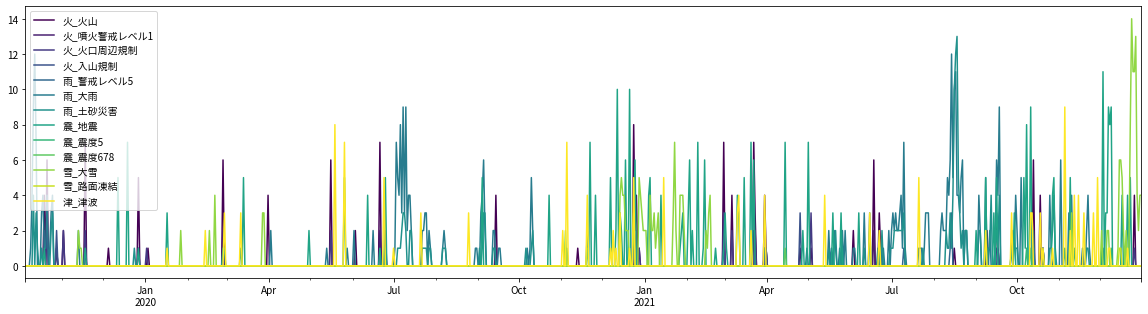

In [27]:
df.iloc[:,:13].plot(figsize=(20,5), cmap='viridis')
plt.show()

#### plot targets

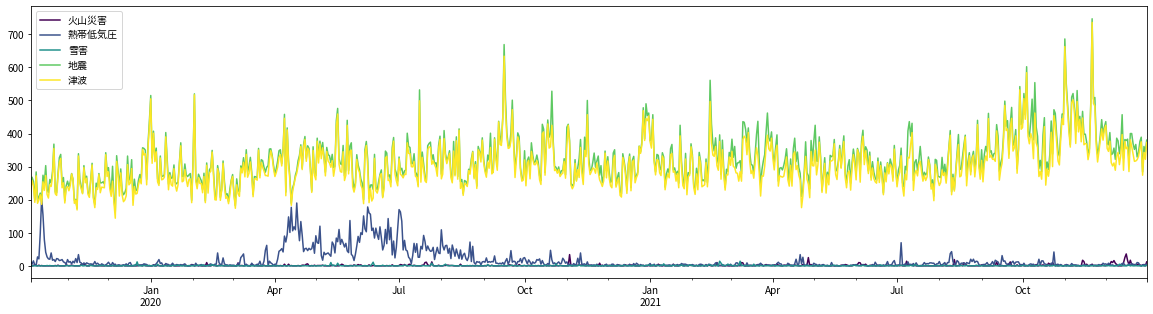

In [28]:
df[['火山災害','熱帯低気圧','雪害','地震','津波']].plot(figsize=(20,5), cmap='viridis')
plt.show()

## Prep for regression

### names of indices

In [29]:
dzs = ['火', '雨', '震', '雪', '津']  # disasters abbreviated
target_names = ['火山災害','熱帯低気圧','地震','雪害','津波']
calendar_vars = ['mtwtf','satsun','holiday_on_weekday']
twitter_feature_names = (
    ['火_火山',      '火_噴火警戒レベル1','火_火口周辺規制','火_入山規制', 
     '雨_警戒レベル5','雨_大雨',          '雨_土砂災害',
     '震_地震',      '震_震度5',         '震_震度678',
     '雪_大雪',      '雪_路面凍結',
     '津_津波']
)

### function ```get_onset_series```

In [30]:
def get_onset_series(ser):
    return (
        pd.DataFrame((
            ser.shift(1)>0, 
            ser.shift(2)==0
        )).T.dropna()
        .all(axis=1)
        .astype(int)
    )

### make lagged features to assess impulse response

In [31]:
df_lags = df[df.columns.difference(['holiday_name'])].copy()

tg_lag_vars, tg_μ_vars = [], []
for i in target_names:
    for j in [1,2,3]:
        df_lags[f"{i}_l{j}"] = df_lags[i].shift(j)
        tg_lag_vars.append(f"{i}_l{j}")
    for j in [7]:
        df_lags[f"{i}_μ{j}"] = df_lags[i].rolling(window=j, closed="left").mean()
        tg_μ_vars.append(f"{i}_μ{j}")
        
tw_lag_vars, tw_ons_vars = [], []
for i in twitter_feature_names:
    for j in [1,2,3]:
        df_lags[f"{i}_l{j}"] = df_lags[i].shift(j)
        tw_lag_vars.append(f"{i}_l{j}")
    ons = get_onset_series(df_lags[i])
    for j in [1,2,3]:
        df_lags[f"{i}_ons{j}"] = ons.shift(j)
        tw_ons_vars.append(f"{i}_ons{j}")

df_lags = df_lags.dropna()

#### prep

In [32]:
XX = df_lags[tg_μ_vars + tg_lag_vars + calendar_vars]
YY = df_lags[target_names]

start_tr = 0
end_tr = 550
end_vl = 700
XXtr, YYtr = XX.copy().iloc[start_tr:end_tr], YY.iloc[start_tr:end_tr]
XXvl, YYvl = XX.copy().iloc[end_tr:end_vl], YY.iloc[end_tr:end_vl]

In [33]:
Xcols = {}
for i,j in zip(dzs, target_names):
    l = (XX.columns[XX.columns.str.startswith(i)].tolist() + 
                   XX.columns[XX.columns.str.startswith(j)].tolist() +
                   calendar_vars)
    l = list(set(l))
    Xcols[i] = l

ycols = {'火':'火山災害','雨':'熱帯低気圧','震':'地震','雪':'雪害','津':'津波'}

Xtr, Xvl = {}, {}
ytr, yvl = {}, {}
for diz in Xcols:
    Xtr[diz] = XXtr[Xcols[diz]]
    Xvl[diz] = XXvl[Xcols[diz]]
    ytr[diz] = YYtr[ycols[diz]]
    yvl[diz] = YYvl[ycols[diz]]

## Linear Regression Runs

### Linear Regression (Ridge regularization penalty)

In [291]:
ri, gs_ri = {}, {}
for diz in Xtr:
    ri[diz] = Ridge()
    gs_ri[diz] = GridSearchCV(ri[diz], {'alpha': [-100,-10,0,10,100]})
    gs_ri[diz].fit(Xtr[diz],ytr[diz])
    print((diz, gs_ri[diz].score(Xvl[diz],yvl[diz]), gs_ri[diz].best_params_))

/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.783e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.22741e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=6.25606e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.07795e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


('火', -0.00501189142264713, {'alpha': 100})
('雨', -0.14062301177958214, {'alpha': 100})


/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.90852e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.74294e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.14581e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=4.26071e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/bhrdwj

('震', 0.15299630451648127, {'alpha': 10})
('雪', -0.05724765176189428, {'alpha': 100})
('津', 0.1285041908777883, {'alpha': 10})


/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.61758e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.02237e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


#### Check coeffs

In [282]:
i = dzs[2]
(pd.DataFrame({
    'feat': Xcols[i],
    'coeffs': gs_ri[i].best_estimator_.coef_.tolist(), 
    'mean': XX[Xcols[i]].mean().tolist(),
    'std': XX[Xcols[i]].std().values.tolist()
})
 .set_index('feat')
 .assign(coeff_x_std=lambda x: x['coeffs'] * x['std'])
 .sort_values(by='coeff_x_std', key=abs, ascending=False)
 
)

,coeffs,mean,std,coeff_x_std
feat,,,,
地震_l1,0.285504,322.245074,72.829330,20.793058
地震_μ7,0.376833,321.836383,52.176317,19.661742
satsun,16.592276,0.285714,0.452032,7.500246
mtwtf,-16.592276,0.714286,0.452032,-7.500246
holiday_on_weekday,34.330584,0.038177,0.191742,6.582625
地震_l3,0.052123,321.971675,72.952955,3.802514
地震_l2,0.018227,322.066502,72.953581,1.329734


## Unused models

### unused code for linear regression

##### old feats

In [31]:
# from sklearn.preprocessing import StandardScaler
# ss = StandardScaler()
# x = df_lags.copy()
# x = ss.fit_transform(x)
# x = pd.DataFrame(x, index = df_lags.index, columns=df_lags.columns)
# df_lags = x.copy()
# del x

### Random Forest

In [43]:
from sklearn.ensemble import RandomForestRegressor

In [44]:
rf, gs_rf = {}, {}
for diz in Xtr:
    rf[diz] = RandomForestRegressor(max_depth=4)
    gs_rf[diz] = GridSearchCV(rf[diz], {'max_depth': [2,4,6,8]})
    gs_rf[diz].fit(Xtr[diz],ytr[diz])
    print((diz, gs_rf[diz].score(Xte[diz],yte[diz]), gs_rf[diz].best_params_))

('火', -0.006572360487464124, {'max_depth': 2})
('雨', -0.06786225536105284, {'max_depth': 4})
('震', 0.09573665331625714, {'max_depth': 4})
('雪', -0.004690366252751543, {'max_depth': 2})
('津', 0.09262411878891985, {'max_depth': 4})


### SVR

In [45]:
from sklearn.svm import SVR

In [46]:
sv, gs_sv = {}, {}
for diz in Xtr:
    sv[diz] = SVR()
    gs_sv[diz] = GridSearchCV(sv[diz], {'C': [-100,-10,0,10,100], 'epsilon':[.05,.1,.15]})
    gs_sv[diz].fit(Xtr[diz],ytr[diz])
    print((diz, gs_sv[diz].score(Xte[diz],yte[diz]), gs_sv[diz].best_params_))

/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
45 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/svm/_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/svm/_base.py", line 

('火', -0.12399029054535537, {'C': 10, 'epsilon': 0.15})


/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
45 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/svm/_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/svm/_base.py", line 

('雨', -0.024478679160186978, {'C': 100, 'epsilon': 0.15})


/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
45 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/svm/_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/svm/_base.py", line 

('震', 0.034543211327605405, {'C': 100, 'epsilon': 0.05})


/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
45 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/svm/_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/svm/_base.py", line 

('雪', -0.05732660081524199, {'C': 10, 'epsilon': 0.15})


KeyboardInterrupt: 

### ARIMA

In [ ]:
pf_ma1 = pf.ARIMA(data=data.dropna().unemp_diff.values, ar=0, ma=1, family=pf.Normal())
pf_ma1_results = pf_ma1.fit("MLE")
pf_ma1_results.summary()

In [ ]:
pf_ma1.plot_predict_is(h=50, figsize=(12,5))

In [ ]:
pf_ma1.plot_predict(h=15,past_values=20,figsize=(12,5))